In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4023256349626435370
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31585705728
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 5441429220824195302
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0"
]


In [2]:
import glob
import random
import os
import numpy as np
from scipy import ndimage as ndi
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc 
import tensorflow as tf
import numpy as np
import scipy.io
import cygan
import BAGAN
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [19]:
#ORAL CANCER 5 fold validation
import os
import cv2




path = '/home/auser04/Oral_cancer/'

can = [cv2.resize(cv2.imread(path + 'cancer/' +s),dsize = (224,224), interpolation=cv2.INTER_CUBIC) for s in os.listdir(path+'cancer')if ".jpg" or ".jpeg"in s.lower()]
nor = [cv2.resize(cv2.imread(path + 'normal/' +s), dsize = (224,224), interpolation=cv2.INTER_CUBIC) for s in os.listdir(path+'normal')if ".jpg"in s.lower()]

can = (np.array(can)-127.5)/127.5
nor = (np.array(nor)-127.5)/127.5
allCAN = np.concatenate((CAN,can,CAN,can),axis=0)
allNOR = np.concatenate((NOR,nor,NOR[0:2],NOR,nor),axis=0)
res_x = np.append(allNOR,allCAN,axis=0)
print(res_x.shape,allCAN.shape,allNOR.shape)
#NOR10 CAN38

In [4]:
import tensorflow as tf
import numpy as np
from keras.datasets import mnist
from keras.applications import VGG19
from keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Add, Concatenate, add
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
import matplotlib.pyplot as plt

In [21]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

class WGAN():
    def __init__(self):
        self.img_rows = 224
        self.img_cols = 224
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = get_discriminator(name = 'c')#self.build_critic()
        print(self.critic.summary())
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = get_resnet_generator(name = 'g')#self.build_generator()
        print(self.generator.summary())
        # The generator takes noise as input and generated imgs
        z = Input(shape=(224, 224, 3))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)



    def train(self, epochs, batch_size, sample_interval=50):

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                #idx = np.random.randint(0, 38, batch_size)
                idx_NOR = np.random.randint(0, NOR.shape[0], batch_size)
                idx_CAN = np.random.randint(0, CAN.shape[0], batch_size)
                N_imgs = NOR[idx_NOR]
                C_imgs = CAN[idx_CAN]
#                 imgs = NOR[idx]#.reshape((28,4,28,3))
#                 gen_inp = CAN[idx]
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(C_imgs)#改

                # Train the critic
                d_loss_real = self.critic.train_on_batch(N_imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------
            #idx = np.random.randint(0, 38, batch_size)
            gen_inp = CAN[idx_NOR]#改
            g_loss = self.combined.train_on_batch(gen_inp, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        #noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(CAN[0:25])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt][:,:,::-1])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

if __name__ == '__main__':
    wgan = WGAN()

In [ ]:
import tensorflow.keras.backend as K

for th in range(0,5):
    K.clear_session()
    gan = GAN()
    thre = 0.8
    NOR = allNOR[th*5:(th+4)*5]
    CAN = allCAN[th*5:(th+12)*5]
    wgan.train(epochs=3000, batch_size=1, sample_interval=50)
    wgan.generator.save_weights("ae_wgen_%d",%th)
    

In [40]:
wgan.generator.save_weights("ae_wgen")

In [37]:
img = wgan.generator.predict(CAN[0:10].reshape(10,224,224,3))

In [13]:
feature = encoder.predict(CAN[2].reshape(1,224,224,3))

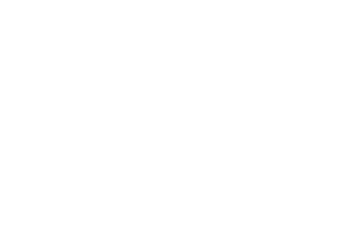

In [39]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = (x_train-127.5) / 127.5, (x_test-127.5) / 127.5

inds = y_train.argsort()
sorted_x = x_train[inds]
sorted_y = y_train[inds]
sorted_x = np.expand_dims(sorted_x, axis=3)
sorted_x = np.tile(sorted_x,(1,1,1,3))
for i in range(10):
    plt.axis('off')
    plt.imsave('/home/auser04/result/six%d.png' %i ,(cv2.resize(sorted_x[i+36020],dsize = (224,224), interpolation=cv2.INTER_CUBIC)))

In [27]:
np.min(CAN+1)

-0.43664732286158725

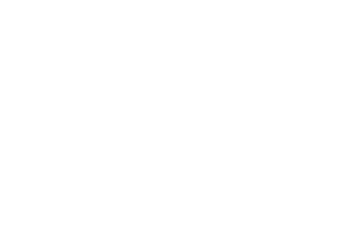

In [38]:
for i in range(10):
    plt.axis('off')
    plt.imsave('/home/auser04/result/decoded_5%d.png' %i ,(img[i][:,:,::-1]+1)/2)

In [29]:
np.max(img)

0.9558387

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


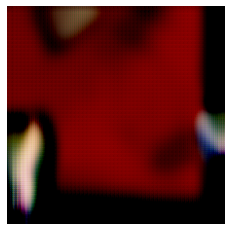

In [22]:
plt.axis('off')
plt.imshow(img[0][:,:,::-1])

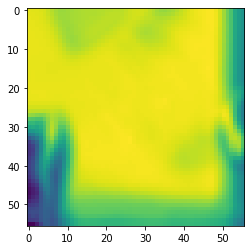

In [19]:
feature.shape
plt.imshow(feature[0,:,:,2].reshape(56,56))

In [12]:
encoder = Model(inputs = wgan.generator.input, outputs = wgan.generator.get_layer('add_8').output)

In [12]:
#wgan.combined.save('/home/auser04/chang/0505_cyganae_combined.h5')

wgan.generator.save('/home/auser04/chang/0505_cyganae_gen.h5')

NotImplementedError: Layer ReflectionPadding2D has arguments in `__init__` and therefore must override `get_config`.

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
#import tensorflow_datasets as tfds

#tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
#cyclegan generator


class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")
    
def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=(224,224,3), name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=(224,224,3), name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)
    
    #自己加的
    x = Flatten()(x)
    x = Dense(1)(x)
    
    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

In [5]:
"""
Title: WGAN-GP overriding `Model.train_step`
Author: [A_K_Nain](https://twitter.com/A_K_Nain)
Date created: 2020/05/9
Last modified: 2020/05/9
Description: Implementation of Wasserstein GAN with Gradient Penalty.
"""

"""
## Wasserstein GAN (WGAN) with Gradient Penalty (GP)
The original [Wasserstein GAN](https://arxiv.org/abs/1701.07875) leverages the
Wasserstein distance to produce a value function that has better theoretical
properties than the value function used in the original GAN paper. WGAN requires
that the discriminator (aka the critic) lie within the space of 1-Lipschitz
functions. The authors proposed the idea of weight clipping to achieve this
constraint. Though weight clipping works, it can be a problematic way to enforce
1-Lipschitz constraint and can cause undesirable behavior, e.g. a very deep WGAN
discriminator (critic) often fails to converge.
The [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf) method proposes an
alternative to weight clipping to ensure smooth training. Instead of clipping
the weights, the authors proposed a "gradient penalty" by adding a loss term
that keeps the L2 norm of the discriminator gradients close to 1.
"""

"""
## Setup
"""

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


"""
## Prepare the Fashion-MNIST data
To demonstrate how to train WGAN-GP, we will be using the
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Each
sample in this dataset is a 28x28 grayscale image associated with a label from
10 classes (e.g. trouser, pullover, sneaker, etc.)
"""

IMG_SHAPE = (28, 28, 3)
# BATCH_SIZE = 512

# # Size of the noise vector
noise_dim = 128

# fashion_mnist = keras.datasets.fashion_mnist
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# print(f"Number of examples: {len(train_images)}")
# print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# # Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
# train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
# train_images = (train_images - 127.5) / 127.5

"""
## Create the discriminator (the critic in the original WGAN)
The samples in the dataset have a (28, 28, 1) shape. Because we will be
using strided convolutions, this can result in a shape with odd dimensions.
For example,
`(28, 28) -> Conv_s2 -> (14, 14) -> Conv_s2 -> (7, 7) -> Conv_s2 ->(3, 3)`.
While peforming upsampling in the generator part of the network, we won't get 
the same input shape as the original images if we aren't careful. To avoid this,
we will do something much simpler:
- In the discriminator: "zero pad" the input to change the shape to `(32, 32, 1)`
for each sample; and
- Ihe generator: crop the final output to match the shape with input shape.
"""


def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

"""
## Create the generator
"""


def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    input_img = keras.Input(shape=(28, 28, 3))

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    #autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder


g_model = get_generator_model()
g_model.summary()

"""
## Create the WGAN-GP model
Now that we have defined our generator and discriminator, it's time to implement
the WGAN-GP model. We will also override the `train_step` for training.
"""


class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        CAN,
        NOR,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.CAN = CAN
        self.NOR = NOR
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.
        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = 19

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
#             random_latent_vectors = tf.random.normal(
#                 shape=(batch_size, self.latent_dim)
#             )
            idx = np.random.randint(0, 38, batch_size)
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(self.CAN[idx], training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(self.NOR[idx], training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, self.NOR[idx], fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        #random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        idx = np.random.randint(0, 38, batch_size)
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(self.CAN[idx], training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


"""
## Create a Keras callback that periodically saves generated images
"""


class GANMonitor(keras.callbacks.Callback):
    def __init__(self, input_img, num_img=3):
        self.num_img = num_img
        self.input_img = input_img

    def on_epoch_end(self, epoch, logs=None):
        #random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        #inp = np.concatenate(input_img)
        generated_images = self.model.generator(self.input_img)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("images/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


"""
## Train the end-to-end model
"""

# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(CAN[0:3], 3)

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    CAN = CAN,
    NOR = NOR,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training

for i in range(20):
    wgan.fit(NOR, batch_size=19, epochs=epochs, callbacks=[cbk])

    """
    Display the last generated images:
    """

    from IPython.display import Image, display

    display(Image("images/generated_img_0_19.png"))
    display(Image("images/generated_img_1_19.png"))
    display(Image("images/generated_img_2_19.png"))

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 128)       

Epoch 1/20
2/2 [==============================] - 1s 554ms/step - d_loss: -63.0819 - g_loss: 56.4739
Epoch 2/20
2/2 [==============================] - 1s 496ms/step - d_loss: -51.2878 - g_loss: 59.1395
Epoch 3/20
2/2 [==============================] - 1s 536ms/step - d_loss: -37.6855 - g_loss: 58.3368
Epoch 4/20
2/2 [==============================] - 1s 484ms/step - d_loss: -56.2599 - g_loss: 56.1687
Epoch 5/20
2/2 [==============================] - 1s 500ms/step - d_loss: -61.6841 - g_loss: 55.5528
Epoch 6/20
2/2 [==============================] - 1s 549ms/step - d_loss: -58.7957 - g_loss: 66.5347
Epoch 7/20
2/2 [==============================] - 1s 546ms/step - d_loss: -63.0248 - g_loss: 57.8730
Epoch 8/20
2/2 [==============================] - 1s 551ms/step - d_loss: -59.0821 - g_loss: 52.4578
Epoch 9/20
2/2 [==============================] - 1s 519ms/step - d_loss: -69.7023 - g_loss: 61.2185
Epoch 10/20
2/2 [==============================] - 1s 549ms/step - d_loss: -46.9387 - g_los

Epoch 1/20
2/2 [==============================] - 1s 472ms/step - d_loss: -42.3699 - g_loss: 40.9037
Epoch 2/20
2/2 [==============================] - 1s 550ms/step - d_loss: -36.8448 - g_loss: 24.1907
Epoch 3/20
2/2 [==============================] - 1s 549ms/step - d_loss: -41.6118 - g_loss: 24.7419
Epoch 4/20
2/2 [==============================] - 1s 535ms/step - d_loss: -41.7097 - g_loss: 24.1243
Epoch 5/20
2/2 [==============================] - 1s 523ms/step - d_loss: -37.2234 - g_loss: 25.5531
Epoch 6/20
2/2 [==============================] - 1s 512ms/step - d_loss: -37.3329 - g_loss: 24.7244
Epoch 7/20
2/2 [==============================] - 1s 505ms/step - d_loss: -40.2492 - g_loss: 28.1534
Epoch 8/20
2/2 [==============================] - 1s 533ms/step - d_loss: -41.1476 - g_loss: 21.0098
Epoch 9/20
2/2 [==============================] - 1s 561ms/step - d_loss: -34.4948 - g_loss: 32.7274
Epoch 10/20
2/2 [==============================] - 1s 497ms/step - d_loss: -30.0541 - g_los

Epoch 1/20
2/2 [==============================] - 1s 485ms/step - d_loss: -32.2160 - g_loss: 25.3023
Epoch 2/20
2/2 [==============================] - 1s 486ms/step - d_loss: -32.3865 - g_loss: 29.4870
Epoch 3/20
2/2 [==============================] - 1s 504ms/step - d_loss: -26.1374 - g_loss: 25.7687
Epoch 4/20
2/2 [==============================] - 1s 483ms/step - d_loss: -34.5827 - g_loss: 31.3777
Epoch 5/20
2/2 [==============================] - 1s 523ms/step - d_loss: -28.4785 - g_loss: 29.1539
Epoch 6/20
2/2 [==============================] - 1s 508ms/step - d_loss: -31.6978 - g_loss: 33.4830
Epoch 7/20
2/2 [==============================] - 1s 514ms/step - d_loss: -33.1046 - g_loss: 31.2230
Epoch 8/20
2/2 [==============================] - 1s 570ms/step - d_loss: -33.7818 - g_loss: 30.7187
Epoch 9/20
2/2 [==============================] - 1s 443ms/step - d_loss: -30.6965 - g_loss: 36.8768
Epoch 10/20
2/2 [==============================] - 1s 529ms/step - d_loss: -34.5581 - g_los

Epoch 1/20
2/2 [==============================] - 1s 476ms/step - d_loss: -31.4991 - g_loss: 32.2545
Epoch 2/20
2/2 [==============================] - 1s 449ms/step - d_loss: -31.5837 - g_loss: 32.9025
Epoch 3/20
2/2 [==============================] - 1s 496ms/step - d_loss: -28.8462 - g_loss: 34.9367
Epoch 4/20
2/2 [==============================] - 1s 497ms/step - d_loss: -25.2904 - g_loss: 34.5030
Epoch 5/20
2/2 [==============================] - 1s 510ms/step - d_loss: -29.9514 - g_loss: 30.5433
Epoch 6/20
2/2 [==============================] - 1s 513ms/step - d_loss: -27.8783 - g_loss: 32.4615
Epoch 7/20
2/2 [==============================] - 1s 498ms/step - d_loss: -29.7585 - g_loss: 36.1260
Epoch 8/20
2/2 [==============================] - 1s 501ms/step - d_loss: -29.7745 - g_loss: 35.5479
Epoch 9/20
2/2 [==============================] - 1s 476ms/step - d_loss: -26.1958 - g_loss: 35.5566
Epoch 10/20
2/2 [==============================] - 1s 516ms/step - d_loss: -29.1868 - g_los

Epoch 1/20
2/2 [==============================] - 1s 553ms/step - d_loss: -23.8385 - g_loss: 31.1094
Epoch 2/20
2/2 [==============================] - 1s 478ms/step - d_loss: -36.5046 - g_loss: 42.5499
Epoch 3/20
2/2 [==============================] - 1s 476ms/step - d_loss: -28.8946 - g_loss: 37.0808
Epoch 4/20
2/2 [==============================] - 1s 499ms/step - d_loss: -34.7331 - g_loss: 42.4786
Epoch 5/20
2/2 [==============================] - 1s 480ms/step - d_loss: -31.6541 - g_loss: 43.9718
Epoch 6/20
2/2 [==============================] - 1s 538ms/step - d_loss: -30.6339 - g_loss: 41.3725
Epoch 7/20
2/2 [==============================] - 1s 504ms/step - d_loss: -24.2680 - g_loss: 38.5920
Epoch 8/20
2/2 [==============================] - 1s 495ms/step - d_loss: -31.7381 - g_loss: 48.0092
Epoch 9/20
2/2 [==============================] - 1s 484ms/step - d_loss: -25.3346 - g_loss: 37.8982
Epoch 10/20
2/2 [==============================] - 1s 475ms/step - d_loss: -26.8581 - g_los

Epoch 1/20
2/2 [==============================] - 1s 456ms/step - d_loss: -25.5062 - g_loss: 56.2342
Epoch 2/20
2/2 [==============================] - 1s 518ms/step - d_loss: -33.4986 - g_loss: 58.5185
Epoch 3/20
2/2 [==============================] - 1s 494ms/step - d_loss: -26.6655 - g_loss: 60.8945
Epoch 4/20
1/2 [==============>...............] - ETA: 0s - d_loss: -19.9338 - g_loss: 62.3350

KeyboardInterrupt: 